<a href="https://colab.research.google.com/github/hammaad2002/PerturbationAnalysis/blob/main/Stage_2_(Perturbation_Analysis_And_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer:**

This notebook is for perturbation analysis and detection of adversarial examples using ML/DL approaches. Long story short, this notebook uses the stored audios from the Stage 1 (Data Generation) pipeline on google drive and uses those audios for feature extraction/perturbation analysis (for now there are only 2 feature extraction methods implemented namely, STFT and zero crossing). And in the end it will use these extracted features, combine them and convert them into structured form for ML algorithms and train them for binary classification (adversarial example detection which is basically one form of defense).

Following is the pipeline describing how the data flows.

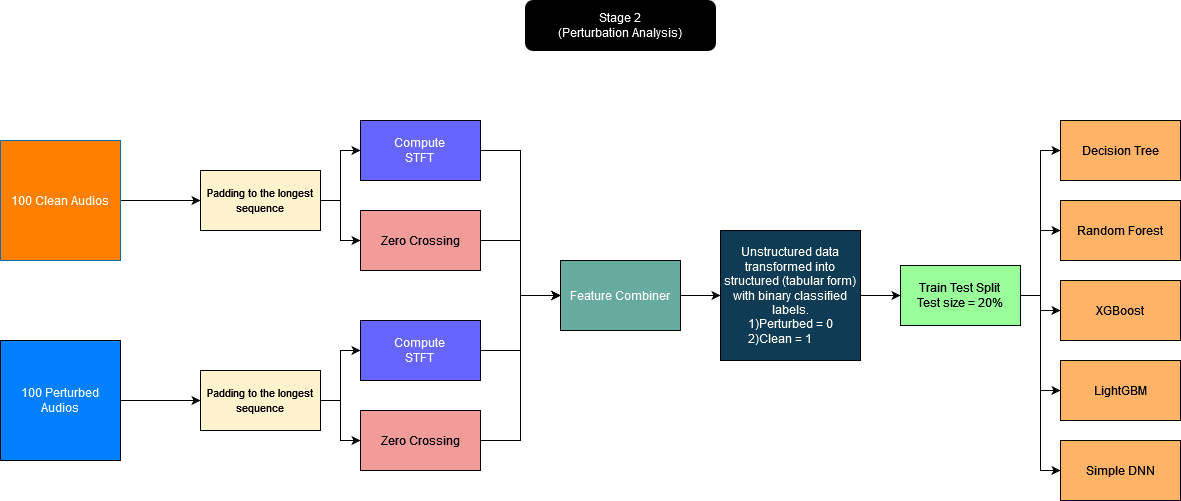

In [ ]:
%%capture
!git clone https://github.com/hammaad2002/PerturbationAnalysis.git
!pip install shap
!git clone https://github.com/hammaad2002/ASRAdversarialAttacks.git

In [ ]:
from typing import Tuple, List
import h5py
import torch
import torchaudio
import numpy as np
from tqdm.auto import tqdm
import librosa
import shap
import matplotlib.pyplot as plt
from ASRAdversarialAttacks.AdversarialAttacks import ASRAttacks
from PerturbationAnalysis.DataPipeline import DataTransform
from IPython.display import Audio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
import io
from googleapiclient.http import MediaIoBaseDownload
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Loading the model from torchaudio model hub
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()

# Checking the device available during the current environment (CUDA is recommended!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing attack class
attack = ASRAttacks(model, device, bundle.get_labels())

# Initializing dataTransform class
dataTransformer = DataTransform(model, attack, device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:04<00:00, 89.1MB/s] 


# Class that include methods to save and download files from google drive

In [ ]:
class DriveAccess(object):
    def __init__(self, scope, creds):
        scope = scope                                            # Define the scope of API access
        creds = creds                                            # Load credentials from JSON key file
        self.drive_service = build('drive', 'v3', credentials=creds)  # Authorize client using credentials
    
    def _search_file_by_name(self, file_name, folder_id):
        query = f"name='{file_name}' and mimeType!='application/vnd.google-apps.folder' and '{folder_id}' in parents and trashed = false"
        results = self.drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
        items = results.get('files', [])
        return items

    def _delete_file(self, file_id):
        try:
            self.drive_service.files().delete(fileId=file_id).execute()
            print(f'File with ID "{file_id}" has been deleted.')
        except HttpError as error:
            print(f'An error occurred: {error}')

    # Function to create and upload a file to Google Drive
    def upload_to_drive(self, file_path, file_name, mime_type, folder_id):
        # Check if the file already exists in the folder
        existing_files = self._search_file_by_name(file_name, folder_id)
        if existing_files:
            for file in existing_files:
                self._delete_file(file['id'])

        try:
            file_metadata = {
                'name': file_name,
                'parents': [folder_id]
            }
            media = MediaFileUpload(file_path, mimetype=mime_type)
            file = self.drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
            print(f'File ID: "{file.get("id")}".')
        except HttpError as error:
            print(f'An error occurred: {error}')
            file = None

        return file.get("id")

    # Function to download a file from Google Drive
    def download_file(self, file_id, destination):
        try:
            request = self.drive_service.files().get_media(fileId=file_id)
            fh = io.BytesIO()
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
                print("Download %d%%." % int(status.progress() * 100))

            fh.seek(0)
            with open(destination, 'wb') as f:
                f.write(fh.read())
                f.close()
            print(f'Successfully downloaded the file to {destination}')
        except HttpError as error:
            print(f'An error occurred: {error}')

    # Function to list all the files stored in my Google Drive's folder
    def list_files_in_folder(self, folder_id):
        query = f"'{folder_id}' in parents and trashed = false"
        results = self.drive_service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
        items = results.get('files', [])
        return items

In [ ]:
# Define the scope of API access
driveScope = ['https://www.googleapis.com/auth/drive']

# Load credentials from JSON key file
creds = Credentials.from_service_account_file(
    '/kaggle/working/PerturbationAnalysis/Credentials/skilled-bonus-389413-02121e893823.json', scopes=driveScope)

# initializing DriveAcess class
drive = DriveAccess(driveScope, creds)

In [ ]:
# this cell basically prints all the datasets according to the attack type stored in my google drive
folder_id = '1NI0ZylqR35rDNJkUpERJTnBX86MSLFhP'                  # this is my folder's id don't change it
files = drive.list_files_in_folder(folder_id)

files_dict = {}
for file in files:
    files_dict[file['name']] = file['id']
    print(f"File Name: {file['name']}, File ID: {file['id']}")

File Name: FGSMTargeted.hdf5, File ID: 1Zz8g6OmSgVezVaBpW5RyO3AQuNuf5JRm
File Name: clean.hdf5, File ID: 1LLaiLRaxIk2nQhEBuF0HWmOUyOaI_zPx


These should be the file names if the notebook convention is followed:
1) FGSM   = 'FGSMTargeted.hdf5'

2) BIM    = 'BIMTargeted.hdf5'

3) PGD    = 'PGDTargeted.hdf5'

4) CW     = 'CWTargeted.hdf5'

5) IMP_CW = 'IMP_CWTargeted.hdf5'

6) Clean  = 'clean.hdf5'

In [ ]:
# for analysis we will need both clean and perturbed data in this notebook I am using FGSM and clean audios
audios1 = 'clean'
audios2 = 'FGSMTargeted'

In [ ]:
# downloading clean dataset from my google drive folder
file_id = files_dict[audios1 + '.hdf5']
destination1 = '/kaggle/working/' + audios1 + '.hdf5'
drive.download_file(file_id, destination1)

Download 100%.
Successfully downloaded the file to /kaggle/working/clean.hdf5


In [ ]:
# downloading FGSM dataset from my google drive folder
file_id = files_dict[audios2 + '.hdf5']
destination2 = '/kaggle/working/' + audios2 + '.hdf5'
drive.download_file(file_id, destination2)

Download 100%.
Successfully downloaded the file to /kaggle/working/FGSMTargeted.hdf5


In [ ]:
# reading all the clean audios stored in the format of .hdf5 extension
clean_audios = []
with h5py.File(destination1, "r") as f:
    for i in tqdm(range(len(f.keys())) ,desc="Reading audios..."):
        string = "cleanAudio" + str(i)
        clean_audios.append(torch.from_numpy(np.array(f[string][()][0], dtype=np.float64).reshape(1,-1)).float())

Reading audios...:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# reading all the clean audios stored in the format of .hdf5 extension
pert_audios = []
with h5py.File(destination2, "r") as f:
    for i in tqdm(range(len(f.keys())) ,desc="Reading audios..."):
        string = "audio" + str(i)
        pert_audios.append(torch.from_numpy(np.array(f[string][()][0], dtype=np.float64).reshape(1,-1)).float())

Reading audios...:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
Audio(clean_audios[0], rate = 16000)

In [ ]:
Audio(pert_audios[0], rate = 16000)

In [ ]:
# Lets see the few clean transcriptions
number_of_example = 5
for i in range(number_of_example):
    temp = clean_audios[i]
    print(attack.INFER(temp.float()).replace("|"," "))

THE BUNGALOW WAS PLEASANTLY SITUATED NEAR THE SHORE 
DON'T ASK ME TO CARRY AN OILY RAG LIKE THAT 
ARE YOU LOOKING FOR EMPLOYMENT 
SHE HAD YOUR DARK SUIT AND GREASY WASHWATER ALL YEAR 
AT TWILIGHT ON THE TWELFTH DAY WE'LL HAVE SHIBLI 


In [ ]:
# Lets see the few perturbed transcriptions
number_of_example = 5
for i in range(number_of_example):
    temp = pert_audios[i]
    print(attack.INFER(temp.float()).replace("|"," "))

IPONGALO WITH LUT QUIT TET WAY TO TO EGAL 
DON'T IAT VERYN EAR TY DRAG LIKE TAT 
ARE YOU LOOKING FOR FORTHEM 
YOU HAD YOUR DARK SUI TREUT YOU WONT FATHER ALL YEAR 
AT TWILIGHT ON THE TWELFTH DAY YOU'LL TAK I TI 


In [ ]:
pad_clean = dataTransformer.pad_audios(clean_audios)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
pad_pert = dataTransformer.pad_audios(pert_audios)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#Lets print their shapes before and after padding
print(f"Before padding the first clean audio had shape {clean_audios[0].shape}")
print(f"After padding the first audio clean have shape {pad_clean[0].shape}")
print(f"Before padding the first perturbed audio had shape {pert_audios[0].shape}")
print(f"After padding the first audio perturbed have shape {pad_pert[0].shape}")

Before padding the first clean audio had shape torch.Size([1, 44749])
After padding the first audio clean have shape torch.Size([1, 98202])
Before padding the first perturbed audio had shape torch.Size([1, 44749])
After padding the first audio perturbed have shape torch.Size([1, 98202])


In [ ]:
#Compute stft on padded clean and perturbed audios
clean_stft = dataTransformer.stft_computer(pad_clean, return_db = True)
pert_stft = dataTransformer.stft_computer(pad_pert, return_db = True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

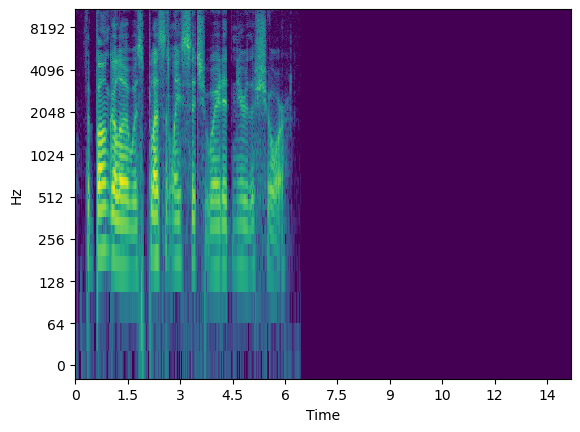

In [ ]:
#Lets check the plot of these STFTs
librosa.display.specshow(clean_stft[0], x_axis = 'time', y_axis = 'log', cmap = 'viridis')

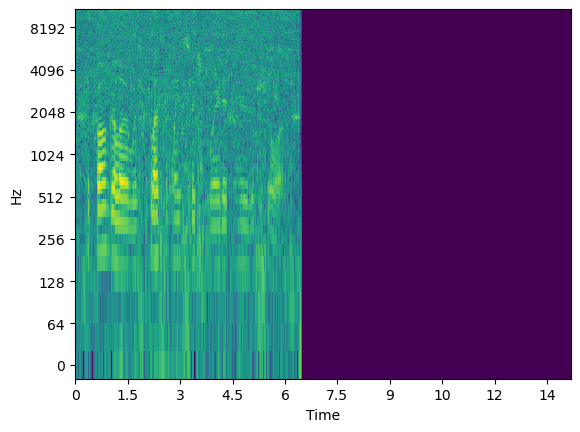

In [ ]:
librosa.display.specshow(pert_stft[0], x_axis = 'time', y_axis = 'log', cmap = 'viridis')

In [ ]:
#Compute zero crossing of clean and perturbed audios
clean_zc = dataTransformer.zero_crossing_computer(pad_clean)
pert_zc = dataTransformer.zero_crossing_computer(pad_pert)

In [ ]:
# Lets check zero crossing of clean and perturbed audio
print(clean_zc[0])
print(pert_zc[0])

8143
17860


In [ ]:
X, Y = dataTransformer.feature_combiner(clean_zc, clean_stft, pert_zc, pert_stft) #creating our features and target labels

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
tempDf = pd.DataFrame(X) #creating dataframe of features for displaying it over here
tempDf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,157018,157019,157020,157021,157022,157023,157024,157025,157026,157027
0,-40.736546,-39.145817,-38.106354,-41.529968,-50.464073,-65.168121,-56.402775,-65.168121,-33.805965,-35.799404,...,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,-65.168121,8143.0
1,-48.547264,-41.843105,-37.399284,-36.610661,-37.656227,-38.913963,-41.237251,-52.245453,-72.855453,-72.398682,...,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,-72.855453,8246.0
2,-41.124702,-44.633148,-48.397766,-65.411110,-45.196266,-39.188198,-42.074795,-43.367580,-45.434151,-49.851612,...,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,-65.411110,4906.0
3,-45.282787,-42.420723,-40.500504,-40.137104,-39.760456,-40.262779,-42.611107,-41.780045,-43.275360,-52.538322,...,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,-63.954964,8610.0
4,-44.371407,-41.722015,-41.709686,-41.952576,-41.875267,-39.932968,-36.644978,-36.779213,-38.847729,-41.198090,...,-67.347900,-67.347900,-67.347900,-67.347900,-67.347900,-67.347900,-67.347900,-67.347900,-67.347900,11928.0


In [ ]:
X = np.array(X)  #converting features to numpy array because of requirement of scikit-learn
Y = np.array(Y)  #converting target labels to numpy array because of requirement of scikit-learn

print(X.shape)   
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(200, 157028)
(200,)
(160, 157028)
(40, 157028)
(160,)
(40,)


# **DECISION TREE**

In [ ]:
# Train the Decision Tree model
modelOne = DecisionTreeClassifier(random_state=42)
modelOne.fit(X_train, Y_train)

# Checking the accuracy using the Test set
modelOne.score(X_test, Y_test)

1.0

In [ ]:
# Make predictions on the testing set
y_predOne = modelOne.predict(X_test)

# Evaluate the model performance
accuracyOne = (y_predOne == Y_test).mean()
print("Accuracy:", accuracyOne)

Accuracy: 1.0


In [ ]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(100*2)):
    example = X[i][np.newaxis, :]
    prediction = modelOne.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/200 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's predi

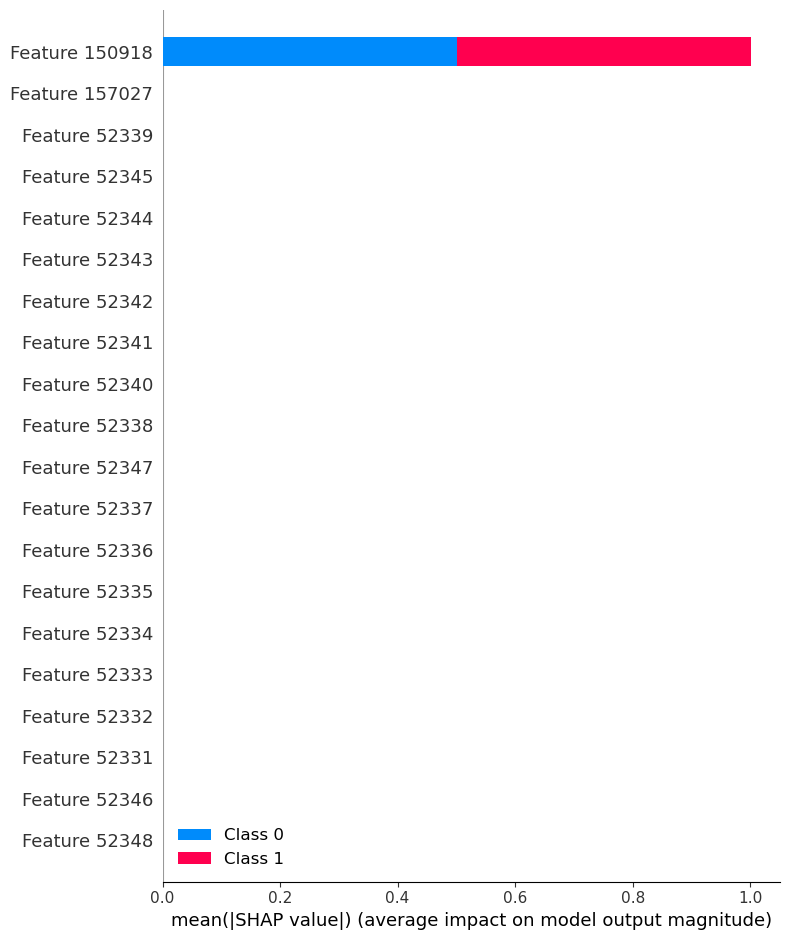

In [ ]:
explainer = shap.TreeExplainer(modelOne)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# **RANDOM FOREST**

In [ ]:
# Train a Random Forest classifier
modelTwo = RandomForestClassifier(random_state=42)
modelTwo.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelTwo.score(X_test, Y_test)

1.0

In [ ]:
# Make predictions on the testing set
y_predTwo = modelTwo.predict(X_test)

# Evaluate the model performance
accuracyTwo = (y_predTwo == Y_test).mean()
print("Accuracy:", accuracyTwo)

Accuracy: 1.0


In [ ]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(100*2)):
    example = X[i][np.newaxis, :]
    prediction = modelTwo.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/200 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's predi

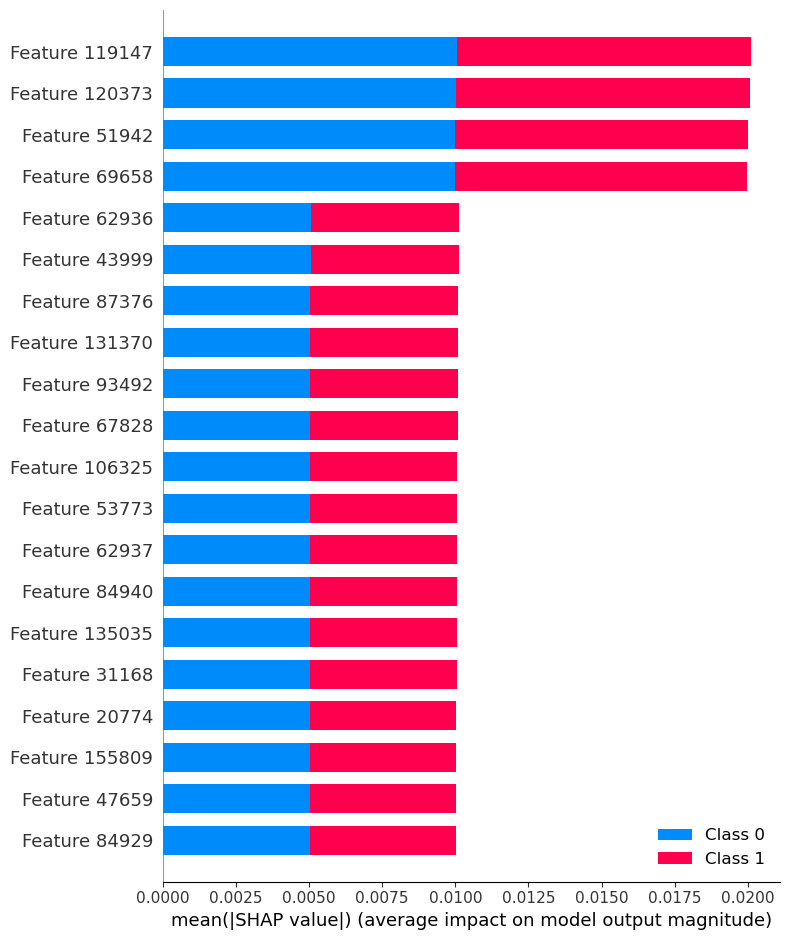

In [ ]:
explainer = shap.TreeExplainer(modelTwo)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# **XGBoost**

In [ ]:
# Train an XGBoost classifier
modelThree = XGBClassifier(random_state=42)
modelThree.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelThree.score(X_test, Y_test)

0.875

In [ ]:
# Make predictions on the testing set
y_predThree = modelThree.predict(X_test)

# Evaluate the model performance
accuracyThree = (y_predThree == Y_test).mean()
print("Accuracy:", accuracyThree)

Accuracy: 0.875


In [ ]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(100*2)):
    example = X[i][np.newaxis, :]
    prediction = modelThree.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/200 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 0 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's predi

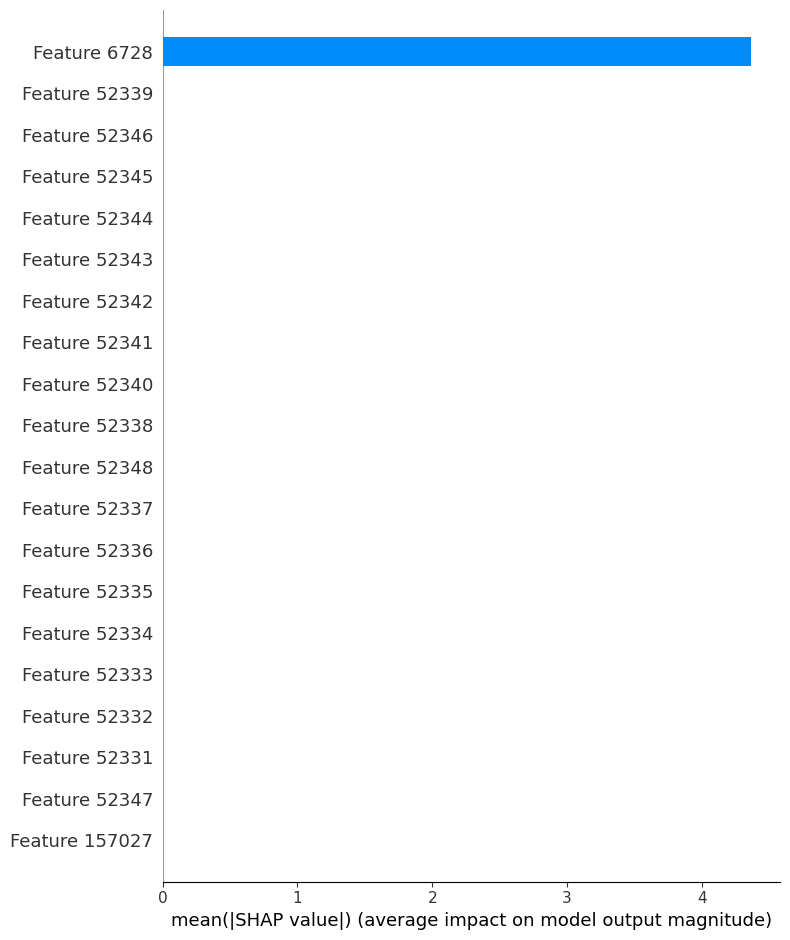

In [ ]:
explainer = shap.TreeExplainer(modelThree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# **LightGBM**

In [ ]:
# Train an XGBoost classifier
modelFour = LGBMClassifier(random_state=42)
modelFour.fit(X_train, Y_train)

# Checking the accuracy using Test set
modelFour.score(X_test, Y_test)

1.0

In [ ]:
# Make predictions on the testing set
y_predFour = modelFour.predict(X_test)

# Evaluate the model performance
accuracyFour = (y_predFour == Y_test).mean()
print("Accuracy:", accuracyFour)

Accuracy: 1.0


In [ ]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(100*2)):
    example = X[i][np.newaxis, :]
    prediction = modelFour.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {prediction[0]} and ground truth is {real_prediction}.")

  0%|          | 0/200 [00:00<?, ?it/s]

Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's prediction is 1 and ground truth is 1.
Model's predi

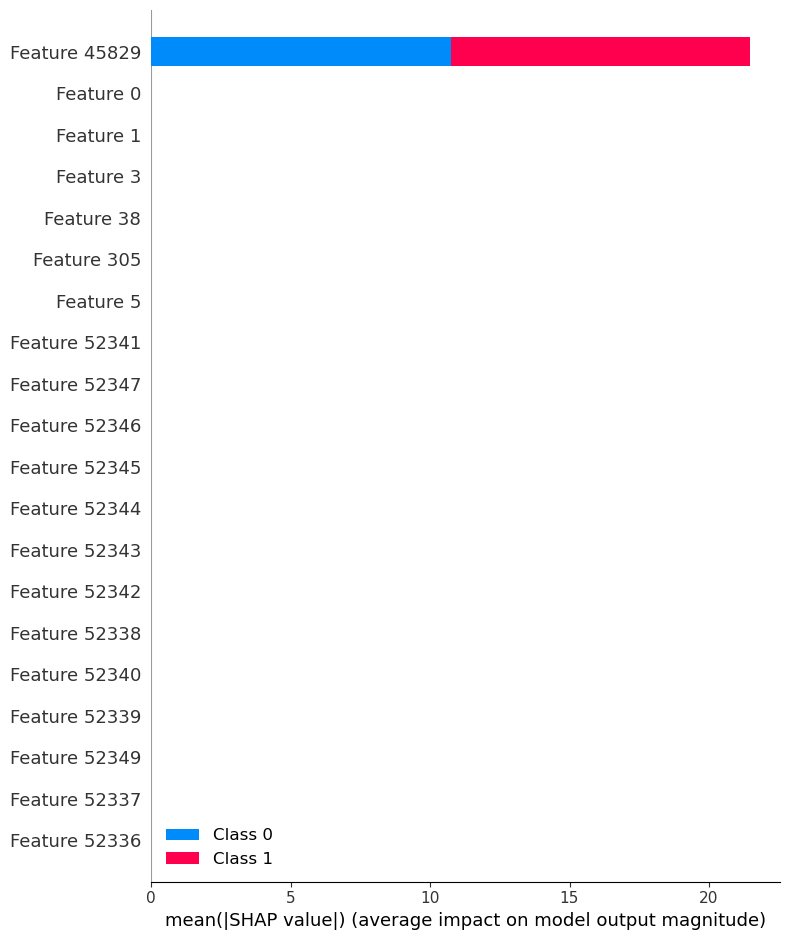

In [ ]:
explainer = shap.TreeExplainer(modelFour)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# **Keras Neural Network (Simple DNN model)**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

modelFive = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

modelFive.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])
modelFive.fit(X_train, Y_train, epochs=50, batch_size=2)

Epoch 1/50
80/80 [==============================] - 3s 6ms/step - loss: 1021.4023 - accuracy: 0.7375
Epoch 2/50
80/80 [==============================] - 0s 6ms/step - loss: 278.3509 - accuracy: 0.8562
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 60.0274 - accuracy: 0.9688
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 54.8940 - accuracy: 0.9625
Epoch 5/50
80/80 [==============================] - 0s 5ms/step - loss: 114.1636 - accuracy: 0.9187
Epoch 6/50
80/80 [==============================] - 0s 6ms/step - loss: 346.9837 - accuracy: 0.8438
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 207.2111 - accuracy: 0.9375
Epoch 8/50
80/80 [==============================] - 0s 5ms/step - loss: 55.6547 - accuracy: 0.9625
Epoch 9/50
80/80 [==============================] - 0s 5ms/step - loss: 21.5942 - accuracy: 0.9812
Epoch 10/50
80/80 [==============================] - 0s 5ms/step - loss: 14.5126 - accuracy: 0.9750
Epo

In [ ]:
# Make predictions on the testing set
y_predFive = modelFive.predict(X_test)

# Evaluate the model performance
correct = 0
wrong = 0
for i in range(len(y_predFive)):
    if np.round(y_predFive[i]) == Y_test[i]:
        correct +=1
    else:
        wrong+=1
accuracyFive = correct / correct + wrong
print("Accuracy:", accuracyFive)

2/2 [==============================] - 0s 6ms/step
Accuracy: 1.0


In [ ]:
# Lets check this unrealistic score using some prediction
for i in tqdm(range(100*2)):
    example = X[i][np.newaxis, :]
    prediction = modelFive.predict(example)
    real_prediction = Y[i]
    print(f"Model's prediction is {np.round(prediction[0])} and ground truth is {real_prediction}.")

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 22ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 21ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 29ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 29ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 21ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 20ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 25ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 20ms/step
Model's prediction is [1.] and ground truth is 1.
1/1 [==============================] - 0s 20ms/step
Model's prediction is [1.] and

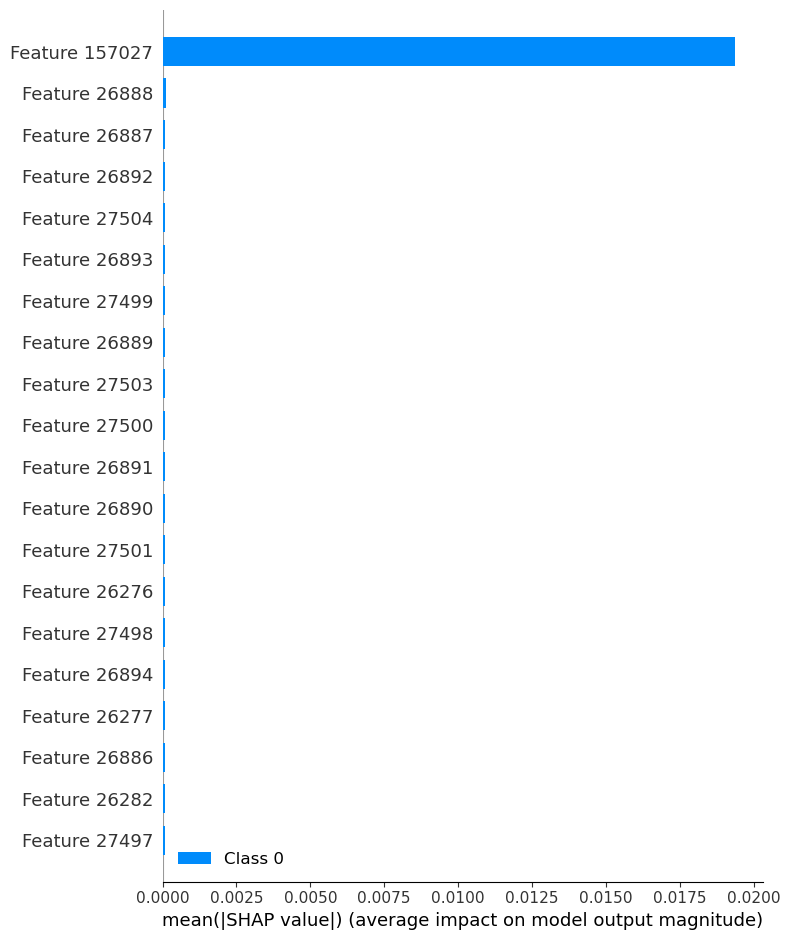

In [ ]:
explainer = shap.DeepExplainer(modelFive, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")